In [1]:
import scanpy as sc
import scvi 
import anndata
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pandas as pd
import seaborn as sb
import scanpy.external as sce
from tqdm import tqdm

torch.cuda.is_available() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scvi.settings.seed = 0

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
scvi.__version__

Global seed set to 0
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
Global seed set to 0


'0.20.1'

In [3]:
adata_org = anndata.read_h5ad('Organoid_new_Gene_raw_sliced_processed_noday13.h5ad')

In [4]:
np.unique(adata_org.obs.org_annot0)

array(['organoid_Adipocytes', 'organoid_Basal', 'organoid_Basal POSTN+',
       'organoid_Capillary arterioles', 'organoid_Companion layer',
       'organoid_Cuticle/cortex', 'organoid_Dermal condensate',
       'organoid_Dermal papilla', 'organoid_Early fibroblasts FRZB+',
       'organoid_Early fibroblasts HOXC5+', 'organoid_Early myocytes',
       'organoid_Fibroblasts POSTN+', 'organoid_Immature basal',
       'organoid_Immature suprabasal', 'organoid_Inner root sheath',
       'organoid_Melanoblasts', 'organoid_Melanocytes',
       'organoid_Merkel cells', 'organoid_Myelinating Schwann cells',
       'organoid_Myoblasts', 'organoid_Myocytes',
       'organoid_Neuroepithelial cells', 'organoid_Neuron progenitors',
       'organoid_Neuron progenitors SPP1+', 'organoid_Outer root sheath',
       'organoid_Periderm', 'organoid_Placode/matrix',
       'organoid_Pre-dermal condensate',
       'organoid_Proliferating melanoblasts',
       'organoid_Schwann cells/Schwann precursors',
    

In [5]:
adata_org.obs['ANNOTATION'] = [a.split('_')[1] for a in adata_org.obs.org_annot0]
fib_lineage = ['Early fibroblasts HOXC5+', 'Pre-dermal condensate', 'Dermal condensate', 'Dermal papilla'] 
adata_query = adata_org[[a in fib_lineage for a in adata_org.obs.ANNOTATION]] 
adata_query.obs['ID'] = np.repeat('Organoid',adata_query.shape[0])
adata_query.obs['DAY'] = [int(d.split('-')[1]) for d in adata_query.obs.day]
adata_query.layers['counts'] = adata_query.X

batch = [] 
for i in range(adata_query.shape[0]):
    batch.append(adata_query.obs.strain[i] + '_' + adata_query.obs.version[i]     ) #adata_query.obs.version[i] + 
adata_query.obs['bbk'] = batch 
adata_org_all = adata_query.copy()

/tmp/ipykernel_7609/3653433419.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_query.obs['ID'] = np.repeat('Organoid',adata_query.shape[0])


In [6]:
pd.crosstab(adata_query.obs.week, adata_query.obs.day)

day,day-29,day-48,day-85,day-133
week,,,,
4-7_fetal_wks,4862,0,0,0
7-10_fetal_wks,0,4653,0,0
14-16_fetal_wks,0,0,4434,0
17-20_fetal_wks,0,0,0,26723


In [7]:
adata_query.obs.bbk

AAACCCAAGAATACAC-1-0      DSP_v3
AAACCCAAGCTAAACA-1-0      DSP_v3
AAACCCAAGTGAACAT-1-0      DSP_v3
AAACCCACAGTCTTCC-1-0      DSP_v3
AAACCCATCACACCCT-1-0      DSP_v3
                          ...   
TTTGGTTGTGATGCCC-1-11    WA25_v2
TTTGTCAAGACAGACC-1-11    WA25_v2
TTTGTCAAGGTGTGGT-1-11    WA25_v2
TTTGTCACAGCGAACA-1-11    WA25_v2
TTTGTCATCAGGCAAG-1-11    WA25_v2
Name: bbk, Length: 40672, dtype: object

In [8]:
adata_query.layers['counts']

<40672x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 92992501 stored elements in Compressed Sparse Row format>

In [9]:
scvi.__version__

'0.20.1'

In [11]:
adata_ref = anndata.read_h5ad('adata_Fibro.h5ad')

In [28]:
adata_ref_all

AnnData object with n_obs × n_vars = 48649 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'A

In [12]:
# ref subsampling from each cluster aiming 20000 cells in total

def reduce_dataset(adata, annotation_column_name):
    # Compiling a reduced representation by subsampling from each cell type to aim for a 50000 cell datase

    cluster_ids = np.unique(adata.obs[annotation_column_name])
    adata_merge = None
    n_processed_clusters = 0 
    n_cell_clusters = len(cluster_ids)

    TARGETTED_n_cells = 20000 # aiming for roughly this
    PERCENT_THRESHOLD = TARGETTED_n_cells*100/adata.shape[0] #PERCENT_THRESHOLD = 30
    print(PERCENT_THRESHOLD)
    MIN_SAMPLE_SIZE = 500
    assert(len(np.unique(adata.obs_names) ) == adata.shape[0]) # ensure we have unique cell ids

    for i in tqdm(range(n_cell_clusters)):
        cluster_id = cluster_ids[i]
        cluster_adata = adata[adata.obs[annotation_column_name] == cluster_id]
        cluster_cell_ids = cluster_adata.obs_names
        n_cluster_cells = len(cluster_cell_ids)
        #print(cluster_id)
        #print('# of cells:', n_cluster_cells)
        if(n_cluster_cells > MIN_SAMPLE_SIZE): # sample only if the cluster size exceeds min sample size
            sample_size = int(np.ceil(n_cluster_cells*PERCENT_THRESHOLD/100))
            #print('sample size: ', sample_size)
            if(sample_size<MIN_SAMPLE_SIZE): # if the sample size becomes less than min sample size
                #print('Change to min sample size ', MIN_SAMPLE_SIZE)
                sample_size = MIN_SAMPLE_SIZE
            samples = np.random.choice(np.arange(n_cluster_cells), sample_size,replace =False) # simple uniform random sampling of cells
            if(n_processed_clusters==0):
                adata_merge = adata[cluster_cell_ids[samples]] 
            else:
                adata_merge = adata_merge.concatenate(adata[cluster_cell_ids[samples]], index_unique = None )
        else:
            #print('NO SAMPLING')
            if(n_processed_clusters==0):
                adata_merge = cluster_adata 
            else:
                adata_merge = adata_merge.concatenate(cluster_adata, index_unique = None )

        n_processed_clusters = n_processed_clusters + 1
    return adata_merge
if(False):
    adata_ref = reduce_dataset(adata_ref, 'ANNOTATION')
    adata_query = reduce_dataset(adata_query, 'ANNOTATION')

In [13]:
#adata_ref = adata_ref_all.copy()
fib_lineage = ['HOXC5+ early fibroblast', 'Pre-dermal condensate', 'Dermal condensate','Dermal papilla',]
adata_ref = adata_ref[[a in fib_lineage for a in adata_ref.obs.joint_annotation_20220202]] 
#adata_ref = adata_ref_all[[c not in ['FRZB+ early fibroblast'] for c in adata_ref_all.obs.joint_annotation_20220202] ] 
adata_ref.obs['ANNOTATION'] = adata_ref.obs.joint_annotation_20220202 
adata_ref.obs['ID'] = np.repeat('Reference',adata_ref.shape[0])
adata_ref.X = adata_ref.layers['counts']

batch = [] 
for i in range(adata_ref.shape[0]):
    batch.append(adata_ref.obs.chemistry_sorting[i] + "_" +  adata_ref.obs.gender[i] +  "_" + adata_ref.obs.donor[i] + "_" + adata_ref.obs.cell_caller[i]  ) 
adata_ref.obs['bbk'] = batch 
adata_ref_all = adata_ref.copy()

/tmp/ipykernel_7609/2935842199.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ref.obs['ANNOTATION'] = adata_ref.obs.joint_annotation_20220202


In [14]:
adata_ref_all

AnnData object with n_obs × n_vars = 48649 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'A

In [15]:
print(np.unique(adata_ref.obs.ANNOTATION)) 
print(np.unique(adata_query.obs.ANNOTATION) )

['Dermal condensate' 'Dermal papilla' 'HOXC5+ early fibroblast'
 'Pre-dermal condensate']
['Dermal condensate' 'Dermal papilla' 'Early fibroblasts HOXC5+'
 'Pre-dermal condensate']


In [16]:
# INTEGRATE REF AND ORGANOID
adata = adata_ref.concatenate(adata_query, batch_key='ref',index_unique=None) 

/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [17]:
adata_all = adata.copy() 

In [20]:
adata_all

AnnData object with n_obs × n_vars = 89321 × 20011
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202', 'A

In [21]:
adata = adata_all.copy()
# remove cell cycle genes
cc_genes = pd.read_csv('regev_lab_cell_cycle_genes.txt', header=None ) # https://notebook.community/theislab/scanpy_usage/180209_cell_cycle/cell_cycle -- 97 CC GENES
cc_genes = np.asarray(cc_genes[0]) 
relevent_cc_genes = [] 
for cc_gene in cc_genes:
    if(cc_gene in adata.var_names):
        relevent_cc_genes.append(cc_gene)
adata = adata[:,np.setdiff1d(adata.var_names,relevent_cc_genes)] 

mito_genes = adata.var_names.str.startswith('MT-') 
total_UMI_count_across_mito_genes = np.sum(adata.X[:, mito_genes],axis=1).A1
total_UMI_count_across_genes = np.sum(adata.X,axis=1).A1 
adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
#sb.distplot(adata.obs['percent_total_mito_UMI']) 

Q1,Q3 = np.percentile(adata.obs['percent_total_mito_UMI'],[25,75])
IQR = Q3-Q1
U = Q3 + (1.5*IQR)
#print(U*100)
adata = adata[adata.obs['percent_total_mito_UMI']<0.08] 
sc.pp.filter_genes(adata, min_cells=3)

def preprocess2(adata):
    sc.pp.normalize_per_cell(adata, 10000) 
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    adata.raw = adata  # keep full dimension safe
    sc.pp.highly_variable_genes(adata, subset=True)
    scvi.settings.seed = 0
    scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="bbk")
    vae = scvi.model.SCVI(adata, n_layers=2, n_latent=10) # gene_likelihood="nb"
    vae.train()
    adata.obsm["X_scVI"] = vae.get_latent_representation()
    sc.pp.neighbors(adata, use_rep="X_scVI",method='gauss')
    sc.tl.umap(adata)
    #sc.tl.leiden(adata)
    return adata

adata = preprocess2(adata)

/tmp/ipykernel_7609/4037563380.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
Global seed set to 0
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 30 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 92/92: 100%|██████████| 92/92 [10:18<00:00,  6.61s/it, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=92` reached.


Epoch 92/92: 100%|██████████| 92/92 [10:18<00:00,  6.73s/it, loss=700, v_num=1]


/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


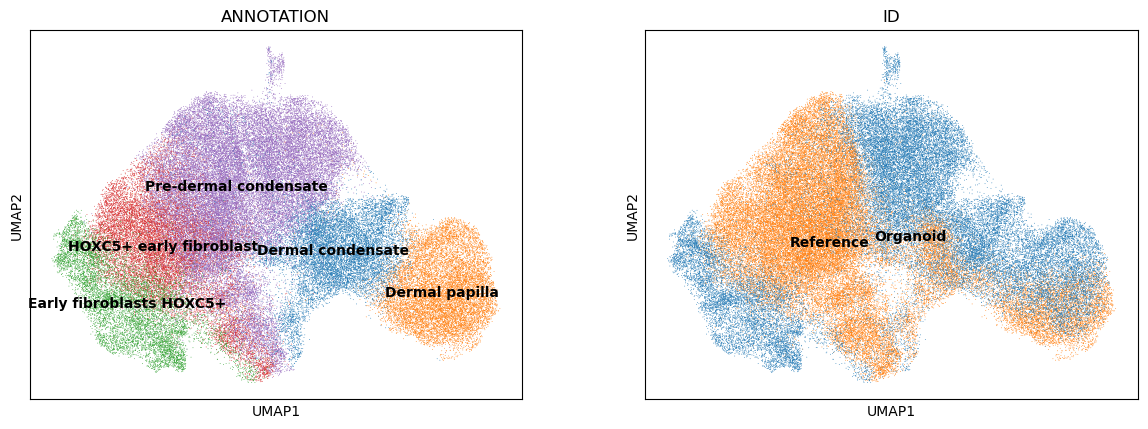

In [23]:
sc.pl.umap(adata, color=['ANNOTATION','ID'],legend_loc='on data')